In [1]:
import pickle
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
import torch.utils.data as Data
from tqdm import tqdm

print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

pandas==1.4.2
torch==1.12.1
numpy==1.21.5


In [3]:
def get_split_label(total_num):
    label = np.array([None] * total_num)
    train_num = int(0.8*total_num)
    valid_num = int(0.1*total_num)
    test_num = total_num - train_num - valid_num

    train_index,valid_index,test_index = Data.random_split(range(total_num),[train_num,valid_num,test_num],generator=torch.Generator().manual_seed(1))
    label[train_index] = 'train'
    label[valid_index] = 'valid'
    label[test_index] = 'test'
    return label

In [2]:
# Bio -> -1
# Chem -> 1
# Overlap -> 0

def split_label_mols():
    with open("./data/bio_products_smi_cor.pkl","rb") as f:
        bio_products_smi_cor = pickle.load(f)
    with open("./data/chem_products_smi_cor.pkl","rb") as f:
        chem_products_smi_cor = pickle.load(f)
    bio_smi_df = pd.DataFrame({'smiles':bio_products_smi_cor,
                               'mol_type':[-1]*len(bio_products_smi_cor)})
    
    chem_smi_df = pd.DataFrame({'smiles':chem_products_smi_cor,
                                'mol_type':[1]*len(chem_products_smi_cor)})
    
    allmol_smi_df = pd.concat([chem_smi_df,bio_smi_df]).groupby('smiles',as_index=False).agg({'mol_type':'mean'})

    chem_mols = allmol_smi_df.loc[allmol_smi_df['mol_type']==1]
    chem_label = get_split_label(len(chem_mols))
    allmol_smi_df.loc[allmol_smi_df['mol_type']==1,'split'] = chem_label

    bio_mols = allmol_smi_df.loc[allmol_smi_df['mol_type']==-1]
    bio_label = get_split_label(len(bio_mols))
    allmol_smi_df.loc[allmol_smi_df['mol_type']==-1,'split'] = bio_label

    overlap_mols = allmol_smi_df.loc[allmol_smi_df['mol_type']==0]
    overlap_label = get_split_label(len(overlap_mols))
    allmol_smi_df.loc[allmol_smi_df['mol_type']==0,'split'] = overlap_label

    return allmol_smi_df

try:
    print('Loading allmol_smi_df dataframe...', end='\r')
    with open("./data/allmol_smi_df.pkl","rb") as f:
        allmol_smi_df = pickle.load(f)
    print('Loading allmol_smi_df dataframe... Done.')
except:
    print('Processing allmol_smi_df dataframe...', end='\r')
    allmol_smi_df = split_label_mols()
    with open("./data/allmol_smi_df.pkl","wb") as f:
        pickle.dump(allmol_smi_df, f)
    print('Processing allmol_smi_df dataframe... Done.')

Loading allmol_smi_df dataframe... Done.


In [4]:
def build_mol_fp_df(fp_label_select, fp_len_select, allmol_smi_df = allmol_smi_df):
    with open("./data/bio_products_smi_cor.pkl","rb") as f:
        bio_products_smi_cor = pickle.load(f)
    with open("./data/chem_products_smi_cor.pkl","rb") as f:
        chem_products_smi_cor = pickle.load(f)
    
    bio_fp_path = f'./data/bio_products_{fp_label_select}_{fp_len_select}_fps.pkl'
    chem_fp_path = f'./data/chem_products_{fp_label_select}_{fp_len_select}_fps.pkl'
    
    with open(bio_fp_path,'rb') as f:
        bio_fp = pickle.load(f)
    with open(chem_fp_path,'rb') as f:
        chem_fp = pickle.load(f) 

    bio_smi_df = pd.DataFrame({'smiles':bio_products_smi_cor,'fps':bio_fp})
    chem_smi_df = pd.DataFrame({'smiles':chem_products_smi_cor,'fps':chem_fp})

    allmol_smi_fp_df = pd.concat([chem_smi_df,bio_smi_df]).groupby('smiles',as_index=False).agg({'fps':'first'})

    allmol_smi_fp_label_df = pd.merge(allmol_smi_fp_df, allmol_smi_df, on="smiles")    
    return allmol_smi_fp_label_df

In [ ]:
def get_train_val_test(fp_label_select, fp_len_select, allmol_smi_df = allmol_smi_df):
    
    fp_name = f'{fp_label_select}_{fp_len_select}'

    print(f'Loading {fp_name}...', end='\r')

    allmol_df = build_mol_fp_df(fp_label_select, fp_len_select, allmol_smi_df = allmol_smi_df)

    mol_type_train = list(allmol_df.loc[allmol_df['split']=='train','mol_type'])
    mol_type_train = torch.tensor(np.array(mol_type_train).reshape(-1,1), dtype=torch.float)
    fps_train = list(allmol_df.loc[allmol_df['split']=='train','fps'])
    fps_train= torch.tensor(np.array(fps_train), dtype=torch.float)
    train_dataset = Data.TensorDataset(fps_train, mol_type_train)

    mol_type_valid = list(allmol_df.loc[allmol_df['split']=='valid','mol_type'])
    mol_type_valid = torch.tensor(np.array(mol_type_valid).reshape(-1,1), dtype=torch.float)
    fps_valid = list(allmol_df.loc[allmol_df['split']=='valid','fps'])
    fps_valid= torch.tensor(np.array(fps_valid), dtype=torch.float)
    valid_dataset = Data.TensorDataset(fps_valid, mol_type_valid)

    mol_type_test = list(allmol_df.loc[allmol_df['split']=='test','mol_type'])
    mol_type_test = torch.tensor(np.array(mol_type_test).reshape(-1,1), dtype=torch.float)
    fps_test = list(allmol_df.loc[allmol_df['split']=='test','fps'])
    fps_test= torch.tensor(np.array(fps_test), dtype=torch.float)
    test_dataset = Data.TensorDataset(fps_test, mol_type_test)
    
    print(f'Loading {fp_name}... Done.')
    print(f'train_dataset: {len(train_dataset)}, valid_dataset: {len(valid_dataset)}, test_dataset: {len(test_dataset)}')
    return train_dataset, valid_dataset, test_dataset


In [5]:
def get_weight(allmol_df = allmol_smi_df):
    bio_num = len(allmol_df.loc[allmol_df['mol_type']== -1])
    chem_num = len(allmol_df.loc[allmol_df['mol_type']== 1])
    overlap_num = len(allmol_df.loc[allmol_df['mol_type']== 0])
    print(f'bio_num:{bio_num}, chem_num:{chem_num}, overlap_num:{overlap_num}')
    weight = [int(chem_num/bio_num),int(chem_num/overlap_num),1]
    print("Wegiht [bio_update,overlap_update,chem_update] is ",weight)
    return weight

def loss_hinge_weighted(output, target, weight = get_weight(), margin = 0.15):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    relu = nn.ReLU()
    input1 = output[:,0].reshape(1,-1).t()
    input2 = output[:,1].reshape(1,-1).t()

    target_copy = target.add(1)
    target_copy = target_copy.clone().detach().t().to(torch.long)
    target_onehot = nn.functional.one_hot(target_copy, num_classes=3).to(torch.float)
    weight = torch.tensor(weight).to(device).to(torch.float)

    weighted_col = target_onehot @ weight
    weighted_col = weighted_col.t()
    
    loss = weighted_col * relu(torch.abs(target)*(-target*(input1-input2)+margin) + torch.abs(torch.abs(target)-1)*(torch.abs(input1-input2)-margin))
    
    loss = torch.mean(loss)
    return loss

bio_num:37424, chem_num:437266, overlap_num:515
Wegiht [bio_update,overlap_update,chem_update] is  [11, 849, 1]


In [2]:
class NeuralNet_1(nn.Module):
    def __init__(self, lrate, loss_fn, in_size, out_size):
        super(NeuralNet_1, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_size, 300),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, out_size),
            nn.Sigmoid()
        )
        self.loss_fn = loss_fn
        self.optimizer = torch.optim.Adam(self.model.parameters(), lrate)
    def forward(self, x):
        y = self.model(x)
        return y
    def step(self, x, y):
        loss = self.loss_fn(x, y)
        return loss

class NeuralNet_3(nn.Module):
    def __init__(self, lrate, loss_fn, in_size, out_size):
        super(NeuralNet_3, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_size, 300),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, out_size),
            nn.Sigmoid()
        )
        self.loss_fn = loss_fn
        self.optimizer = torch.optim.Adam(self.model.parameters(), lrate)
    def forward(self, x):
        y = self.model(x)
        return y
    def step(self, x, y):
        loss = self.loss_fn(x, y)
        return loss

class NeuralNet_5(nn.Module):
    def __init__(self, lrate, loss_fn, in_size, out_size):
        super(NeuralNet_5, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_size, 300),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, out_size),
            nn.Sigmoid()
        )
        self.loss_fn = loss_fn
        self.optimizer = torch.optim.Adam(self.model.parameters(), lrate)
    def forward(self, x):
        y = self.model(x)
        return y
    def step(self, x, y):
        loss = self.loss_fn(x, y)
        return loss

In [14]:
def train_model(fp_label_select, fp_len_select, allmol_smi_df = allmol_smi_df):
    # accuracies = []
    EPOCH = 21
    check_points = [10,15,20]
    batch_size = 4096
    loss_fn = loss_hinge_weighted
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    in_size = int(fp_len_select)
    sfscore_net_1 = NeuralNet_1(lrate=1e-5, loss_fn=loss_fn, in_size=in_size, out_size=2)
    sfscore_net_3 = NeuralNet_3(lrate=1e-5, loss_fn=loss_fn, in_size=in_size, out_size=2)
    sfscore_net_5 = NeuralNet_5(lrate=1e-5, loss_fn=loss_fn, in_size=in_size, out_size=2)
    sfscore_net_list = [sfscore_net_1,sfscore_net_3,sfscore_net_5]
    sfscore_net_name = ['1_layer','3_layer','5_layer']

    train_dataset, valid_dataset, test_dataset = get_train_val_test(fp_label_select,fp_len_select,allmol_smi_df)
    train_loader = Data.DataLoader(train_dataset, shuffle=True, 
                                batch_size=batch_size, num_workers=4)
    valid_loader = Data.DataLoader(valid_dataset, shuffle=True, 
                                batch_size=batch_size)
    
    for (score_net,net_name) in zip(sfscore_net_list,sfscore_net_name):
        train_losses = []
        valid_losses = []
        score_net.to(device)
        score_net.train()
        for epoch in range(EPOCH):
            step_loss = []
            with tqdm(train_loader, unit="batch") as tepoch:
                for train_batch_x, train_batch_y in tepoch:
                    tepoch.set_description(f"{fp_label_select}_{fp_len_select}_{net_name} Epoch {epoch}")
                    
                    out = score_net(train_batch_x.to(device))
                    loss = score_net.loss_fn(out, train_batch_y.to(device).float())
                    
                    score_net.optimizer.zero_grad()
                    loss.backward()
                    score_net.optimizer.step()
                    step_loss.append(loss.item()) 
                train_losses.append(sum(step_loss)/len(step_loss))
                # get valid loss
                score_net.eval()
                with torch.no_grad():
                    step_loss = []
                    for step, (valid_x,valid_y) in enumerate(valid_loader):
                        valid_out = score_net(valid_x.to(device))
                        valid_loss = score_net.loss_fn(valid_out, valid_y.to(device).float())
                        step_loss.append(valid_loss.item())
                    valid_losses.append(sum(step_loss)/len(step_loss))
                score_net.train()
                # save model
                if epoch in check_points:
                    model_name = f'{fp_label_select}_{fp_len_select}_{net_name}_epoch{epoch}'
                    torch.save(score_net.state_dict(),f'./saved_model/{model_name}.pt')
        # save loss
        losses = [train_losses,valid_losses]
        losses_name = f'{fp_label_select}_{fp_len_select}_{net_name}_train_valid_loss'
        with open(f"./saved_model/{losses_name}.pkl","wb") as f:
            pickle.dump(losses, f)
    return None

~ 40 min

In [15]:
fp_label = ['ecfp4','map4']
fp_len = ['1024','2048','4096']
for fp_label_select in fp_label:
    for fp_len_select in fp_len:
        train_model(fp_label_select,fp_len_select)

Loading ecfp4_1024... Done.
train_dataset: 380163, valid_dataset: 47519, test_dataset: 47523


ecfp4_1024_5_layer Epoch 20: 100%|██████████| 93/93 [00:03<00:00, 26.22batch/s]


Loading ecfp4_2048... Done.
train_dataset: 380163, valid_dataset: 47519, test_dataset: 47523


ecfp4_2048_5_layer Epoch 20: 100%|██████████| 93/93 [00:04<00:00, 20.61batch/s]


Loading ecfp4_4096... Done.
train_dataset: 380163, valid_dataset: 47519, test_dataset: 47523


ecfp4_4096_5_layer Epoch 20: 100%|██████████| 93/93 [00:06<00:00, 14.91batch/s]


Loading map4_1024... Done.
train_dataset: 380163, valid_dataset: 47519, test_dataset: 47523


map4_1024_5_layer Epoch 20: 100%|██████████| 93/93 [00:03<00:00, 23.66batch/s]


Loading map4_2048... Done.
train_dataset: 380163, valid_dataset: 47519, test_dataset: 47523


map4_2048_5_layer Epoch 20: 100%|██████████| 93/93 [00:05<00:00, 18.51batch/s]


Loading map4_4096... Done.
train_dataset: 380163, valid_dataset: 47519, test_dataset: 47523


map4_4096_5_layer Epoch 20: 100%|██████████| 93/93 [00:06<00:00, 14.50batch/s]


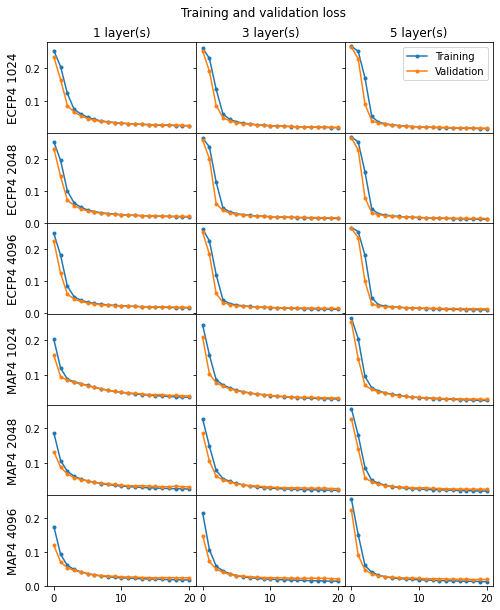

In [5]:
import matplotlib.pyplot as plt
import glob
def draw_loss():
    loss_paths = glob.glob ('./saved_model/*loss.pkl')
    loss_paths.sort()
    model_names = [path.split('/')[2] for path in loss_paths]
    
    fig = plt.figure(figsize=(8, 10))
    gs = fig.add_gridspec(6, 3, hspace=0, wspace=0)
    axs = gs.subplots(sharex='col', sharey='row')

    for (path, model_name, ax) in zip(loss_paths,model_names,axs.ravel()):
        with open(path,"rb") as f:
            losses = pickle.load(f)
        train_losses = losses[0]
        valid_losses = losses[1]

        ax.plot(train_losses,'.-')
        ax.plot(valid_losses,'.-')

    fig.suptitle('Training and validation loss',y=0.93)
    axs[0,2].legend(['Training','Validation'])
    cols = ['{} layer(s)'.format(col) for col in [1,3,5]]
    fp_label = ['ECFP4','MAP4']
    fp_len = ['1024','2048','4096']
    rows = ['{} {}'.format(lab,f_len) for lab in fp_label for f_len in fp_len]
    for ax, col in zip(axs[0], cols):
        ax.set_title(col)
    for ax, row in zip(axs[:,0], rows):
        ax.set_ylabel(row, rotation=90, size='large')
    
    plt.savefig('./figure/train_validation_loss.pdf')  
    plt.show()
    return None
draw_loss()

In [7]:
def get_prec_recall(pred_out,real_label):
    '''
    px.index = ['bio','overlap','chem']
    px.columns = ['Precision','Recall','F1']
    '''
    real_label_diff = pred_out[:,0] - pred_out[:,1]
    mask_chem = real_label_diff > 0.15
    mask_bio = real_label_diff < -0.15
    
    pred_label = torch.zeros(len(pred_out),1)
    
    pred_label[mask_chem] = 1
    pred_label[mask_bio] = -1
    
    RP = torch.zeros(3,3)
    for i in range(len(real_label)):
        if real_label[i] == -1:
            row = 0
            if pred_label[i] == -1:
                RP[row,0] += 1
            if pred_label[i] == 0:
                RP[row,1] += 1
            if pred_label[i] == 1:
                RP[row,2] += 1
        if real_label[i] == 0:
            row = 1
            if pred_label[i] == -1:
                RP[row,0] += 1
            if pred_label[i] == 0:
                RP[row,1] += 1
            if pred_label[i] == 1:
                RP[row,2] += 1
        if real_label[i] == 1:
            row = 2
            if pred_label[i] == -1:
                RP[row,0] += 1
            if pred_label[i] == 0:
                RP[row,1] += 1
            if pred_label[i] == 1:
                RP[row,2] += 1
    
    result_mx = torch.zeros(3,3) # Pre,recall, F1
    for row in range(3):
        for col in range(3):
            if col == 0:
                result_mx[row,col] = RP[row,row]/sum(RP[:,row])
            if col == 1:
                result_mx[row,col] = RP[row,row]/sum(RP[row,:])
            if col == 2:
                result_mx[row,col] = 2 * result_mx[row,0] * result_mx[row,1] /(result_mx[row,0] + result_mx[row,1])
    # print(result_mx)
    return result_mx

def load_all_model():
    model_paths = glob.glob ('./saved_model/*.pt')
    model_paths.sort()
    return model_paths

def get_accuracy():
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    result_dict = dict()
    model_paths = load_all_model()

    old_fp_label_select = None
    old_fp_len_select = None

    for model_path in model_paths:
        model_name = model_path.split('/')[-1]
        fp_label_select = model_name.split('_')[0]
        fp_len_select = model_name.split('_')[1]

        if fp_label_select == old_fp_label_select and fp_len_select == old_fp_len_select:
            pass
        else:
            _,valid_dataset,_ = get_train_val_test(fp_label_select,fp_len_select)
            old_fp_label_select = fp_label_select
            old_fp_len_select = fp_len_select
        val_loader = Data.DataLoader(valid_dataset, batch_size=len(valid_dataset))
        val_x, val_y = next(iter(val_loader))
        val_x = val_x.to(device)

        in_size = int(model_name.split('_')[1])
        layer_num = int(model_name.split('_')[2])
        loss_fn = loss_hinge_weighted
        if layer_num == 1:
            score_net =  NeuralNet_1(lrate=1e-5, loss_fn=loss_fn, in_size=in_size, out_size=2)
        elif layer_num == 3:
            score_net =  NeuralNet_3(lrate=1e-5, loss_fn=loss_fn, in_size=in_size, out_size=2)
        elif layer_num == 5:
            score_net =  NeuralNet_5(lrate=1e-5, loss_fn=loss_fn, in_size=in_size, out_size=2)
        score_net.load_state_dict(torch.load(model_path))
        score_net.to(device)
        score_net.eval()
        with torch.no_grad():
            out = score_net(val_x)
            result_mx = get_prec_recall(out,val_y)
            
        result_dict[model_path] = result_mx
    return result_dict

In [8]:
try:
    with open("./data/accuracy_result_dict.pkl","rb") as f:
        accuracy_result_dict = pickle.load(f)
except:
    accuracy_result_dict = get_accuracy()
    with open("./data/accuracy_result_dict.pkl","wb") as f:
        pickle.dump(accuracy_result_dict, f)

In [69]:
idx_arrays = [
    [],
    []
]
acc_values = []
for idx, value in accuracy_result_dict.items():
    idx_arrays[0].extend([idx.replace('./saved_model/','').replace('.pt','')]*3)
    idx_arrays[1].extend(['Enzy','Overlap','Chem'])
    acc_values.extend(value.numpy())
accuracy_result_pd = pd.DataFrame(acc_values, index=idx_arrays, columns=['Precision','Recall','F1'])
accuracy_result_pd.to_csv('../data/accuracy_result_pd.csv')

In [35]:
overlap_result_dict = dict()

for item,key in accuracy_result_dict.items():
    model_name = item.split('/')[-1]
    epoch = int(model_name.split('_')[-1].replace('epoch','').replace('.pt',''))
    overlap_result_dict[item] = float(key[:,0].mean()*key[:,1].mean()*(key[:,2].mean())/(epoch**0.5))

In [38]:
max_value = max(overlap_result_dict, key=overlap_result_dict.get)
 
print("Maximum value = ",max_value)

Maximum value =  ./saved_model/ecfp4_4096_3_layer_epoch10.pt


In [39]:
accuracy_result_dict[max_value]

tensor([[0.9780, 0.8672, 0.9193],
        [0.0106, 0.9804, 0.0209],
        [0.9994, 0.9021, 0.9483]])

In [40]:
overlap_result = np.array(list(overlap_result_dict.values())).reshape(6,9)
df_col = pd.MultiIndex.from_tuples([('1 layer(s)', '10 epoch'),('1 layer(s)', '15 epoch'),('1 layer(s)', '20 epoch'),
                           ('3 layer(s)', '10 epoch'),('3 layer(s)', '15 epoch'),('3 layer(s)', '20 epoch'),
                           ('5 layer(s)', '10 epoch'),('5 layer(s)', '15 epoch'),('5 layer(s)', '20 epoch')])
df = pd.DataFrame(overlap_result*10,index=['ECFP4 1024','ECFP4 2048','ECFP4 4096','MAP4 1024','MAP4 2048','MAP4 4096'],
                  columns=df_col)
df

1 layer(s)                     3 layer(s)                      \
             10 epoch  15 epoch  20 epoch   10 epoch  15 epoch  20 epoch   
ECFP4 1024   1.086232  0.908346  0.811103   1.168617  0.973353  0.837549   
ECFP4 2048   1.130109  0.956938  0.845463   1.178620  0.995266  0.863770   
ECFP4 4096   1.183714  0.990859  0.873342   1.209079  1.014483  0.881092   
MAP4 1024    0.966514  0.823495  0.741576   1.033726  0.876684  0.777234   
MAP4 2048    1.070257  0.906651  0.804349   1.131897  0.952690  0.836431   
MAP4 4096    1.150466  0.970590  0.835807   1.195529  1.012972  0.888078   

           5 layer(s)                      
             10 epoch  15 epoch  20 epoch  
ECFP4 1024   1.151083  0.959681  0.837117  
ECFP4 2048   1.193958  1.007697  0.883860  
ECFP4 4096   1.206752  1.023480  0.897970  
MAP4 1024    1.041349  0.886753  0.769456  
MAP4 2048    1.141496  0.949233  0.827355  
MAP4 4096    1.206577  1.000368  0.879314

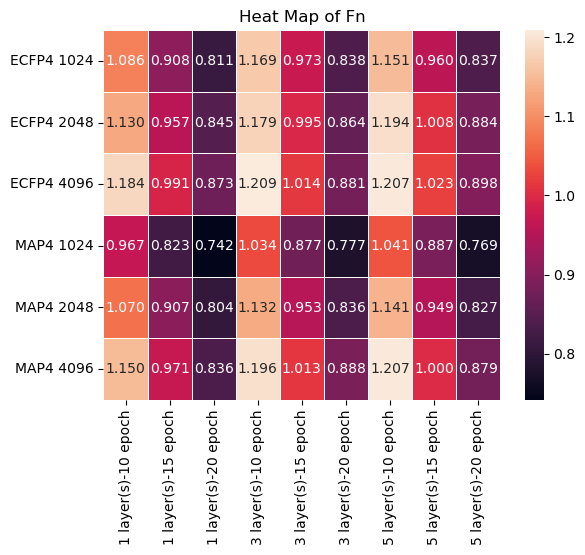

In [51]:
import seaborn as sns
sns.reset_defaults() 
ax = sns.heatmap( df , linewidth = 0.5, annot=True, fmt='.3f' )

plt.xlabel('')
plt.title( "Heat Map of Fn" )
plt.show()